In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from ast import literal_eval
from PIL import Image

# 1. 데이터 load

In [2]:
user = pd.read_csv('data/선호도.csv')
user = user.drop(columns = ['Unnamed: 0'], axis = 1)
user.tail(1)

,user,genre,like,dislike
103,103,['순정'],"['알고있지만', '연애혁명']",['nan']


In [3]:
webtoons = pd.read_csv('data/webtoons_img_sim.csv')
webtoons = webtoons.drop(columns = ['Unnamed: 0'], axis = 1)
webtoons.tail(1)

,id,p_id,title,genre,platform,thumbnail
7459,7459,3595,Game,순정,lezhin,https://ccdn.lezhin.com/v2/comics/468457183484...


In [4]:
sim = np.load('data/features_npy.npy')

#### matplotlib 한글 폰트 설정

In [5]:
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

## Class: 이미지 유사도

In [6]:
class image_sim():
    
    def __init__(self, users, features, webtoons):
        self.users = user
        self.features = features
        self.webtoons = webtoons
    
    # return best10
    def get_ith_sim(self, user_id):
        
        # 1. user가 마지막으로 본('좋아요'를 누른) 웹툰
        def get_index(title):
            row = self.webtoons.loc[self.webtoons['title']==title].loc[:, 'id'].values
            return row[0]
        row = literal_eval(self.users.loc[user_id,'like'])[-1]
        row = get_index(row)

        # 2. cosine 유사도 계산 →  최대 best10
        sim = np.zeros(len(self.features))
        row_image = torch.from_numpy(self.features[row]).unsqueeze(0)
        for col in range(len(self.features)):
            col_image = torch.from_numpy(self.features[col]).unsqueeze(0)
            # cosine 유사도
            cos = nn.CosineSimilarity(dim=1, eps=1e-6)
            sim[col] = cos(row_image, col_image)
        best10 = np.argsort(sim)
        best10 = best10[-11:][::-1][1:11]
        
        #### 0.78 이상만 pick
        idx = 9
        for i in range(len(best10)):
            if best10[i] < 0.8:
                idx = i
                break
        best10 = best10[:idx]

        # 3. user['genre']와 겹치는 웹툰 우선 배치
        def genre_sort(best10):
            count = []
            genre_list = ['일상', '개그', '판타지', '액션', '드라마', '순정', '감성', '스릴러', '시대극', '스포츠']
            for i in range(len(best10)):
                c = 0
                if webtoons.loc[best10[i], 'genre'] in genre_list:
                    c += 1
                count.append(c)
                
            best10 = [x for _,x in sorted(zip(count,best10))][::-1]
            return best10
        best10 = genre_sort(best10)
        
        return row, best10
    
    def show(self,k,img_list):
        
        platform = str(self.webtoons.loc[k, 'platform'])
        p_id = str(self.webtoons.loc[k, 'p_id'])
        title = str(self.webtoons.loc[k, 'title'])
        filename = 'thumbs/' + platform + '_' + p_id + '.jpg'
        img = Image.open(filename)
        
        plt.figure(figsize=(4,4))
        plt.title(title, size=20)
        plt.imshow(img)
        plt.axis('off')
        plt.show()
        
        pltsize = 8
        plt.figure(figsize = (4 * pltsize, pltsize))
        for i in range(len(img_list)):
            plt.subplot(2, 5, i+1)
            plt.axis('off')
            
            platform = str(self.webtoons.loc[img_list[i], 'platform'])
            p_id = str(self.webtoons.loc[img_list[i], 'p_id'])
            title = str(self.webtoons.loc[img_list[i], 'title'])
            filename = 'thumbs/' + platform + '_' + p_id + '.jpg'            
            img = Image.open(filename)
            
            plt.title(title, size=20)
            plt.imshow(img)
        plt.show()

In [7]:
result = image_sim(user, sim, webtoons)

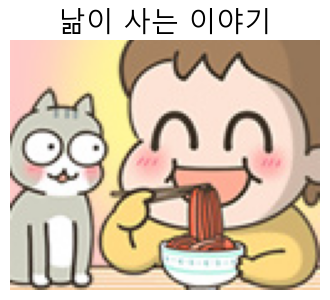

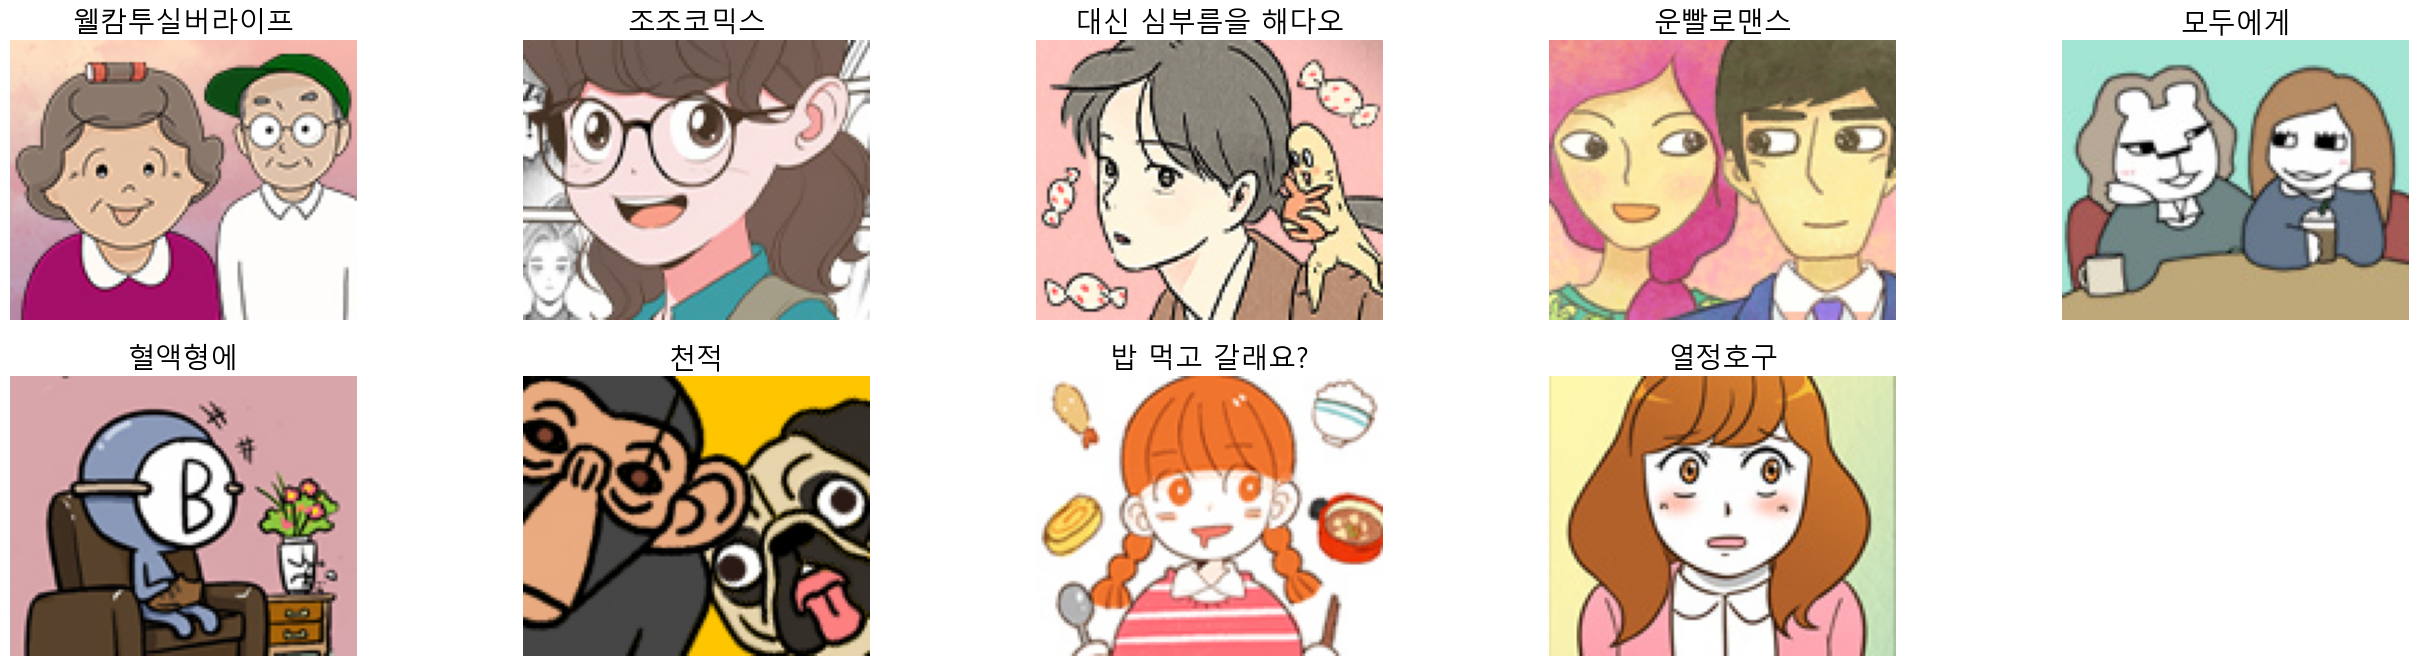

In [12]:
k, best10 = result.get_ith_sim(4) # input n: n번째 유저, output: n번째 유저가 마지막으로 본 웹툰, 유사 그림체 웹툰 list
result.show(k, best10)